# Coding Exercise: Model Agnostic Meta Learning

For this tutorial, we will be showcasing use of Model Agnostic Meta Learning, to learn a simple curve of sinusoidal data. In second part of this tutorial, which can be found on github, we will learn about how to train MAML on Mini-Image Net.
############## Link: http://www.sagargv.com/blog/meta-learning-in-pytorch/

Let's Begin!!!!

#### Step 1: Import Libraries 

In [1]:
import math
import random
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 2: Let's create a simple neural network architecture, which is going to learn the sinusoidal curve. 
We are using this very small network, as we don't need a big one to learn a curve.

In [2]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])
    return x

In [3]:
params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]


#### step 3: set up parameters for training 

In [4]:
opt = torch.optim.SGD(params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2

In [5]:
for it in range(100000): # training for 1 million iterations
    b = 0 if random.choice([True, False]) else math.pi

    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(x + b)

    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f = net(x, new_params)
        loss = F.l1_loss(f, y)

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 100 == 0: 
            print ('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, loss))

    v_f = net(v_x, new_params)
    loss2 = F.l1_loss(v_f, v_y)
    loss2.backward()

    opt.step()

    if it % 100 == 0: 
        print ('Iteration %d -- Outer Loss: %.4f' % (it, loss2))



Iteration 0 -- Inner loop 0 -- Loss: 1.1359
Iteration 0 -- Inner loop 1 -- Loss: 0.7109
Iteration 0 -- Inner loop 2 -- Loss: 0.5584
Iteration 0 -- Inner loop 3 -- Loss: 0.4140
Iteration 0 -- Inner loop 4 -- Loss: 0.4300
Iteration 0 -- Outer Loss: 0.5985
Iteration 100 -- Inner loop 0 -- Loss: 0.5875
Iteration 100 -- Inner loop 1 -- Loss: 0.5725
Iteration 100 -- Inner loop 2 -- Loss: 0.5579
Iteration 100 -- Inner loop 3 -- Loss: 0.5441
Iteration 100 -- Inner loop 4 -- Loss: 0.5306
Iteration 100 -- Outer Loss: 0.7948
Iteration 200 -- Inner loop 0 -- Loss: 0.7791
Iteration 200 -- Inner loop 1 -- Loss: 0.7642
Iteration 200 -- Inner loop 2 -- Loss: 0.7499
Iteration 200 -- Inner loop 3 -- Loss: 0.7361
Iteration 200 -- Inner loop 4 -- Loss: 0.7225
Iteration 200 -- Outer Loss: 0.5176
Iteration 300 -- Inner loop 0 -- Loss: 0.5916
Iteration 300 -- Inner loop 1 -- Loss: 0.5889
Iteration 300 -- Inner loop 2 -- Loss: 0.5862
Iteration 300 -- Inner loop 3 -- Loss: 0.5836
Iteration 300 -- Inner loop 4 

Iteration 3100 -- Inner loop 0 -- Loss: 0.7185
Iteration 3100 -- Inner loop 1 -- Loss: 0.7058
Iteration 3100 -- Inner loop 2 -- Loss: 0.6929
Iteration 3100 -- Inner loop 3 -- Loss: 0.6798
Iteration 3100 -- Inner loop 4 -- Loss: 0.6664
Iteration 3100 -- Outer Loss: 0.7994
Iteration 3200 -- Inner loop 0 -- Loss: 0.4333
Iteration 3200 -- Inner loop 1 -- Loss: 0.4237
Iteration 3200 -- Inner loop 2 -- Loss: 0.4140
Iteration 3200 -- Inner loop 3 -- Loss: 0.4043
Iteration 3200 -- Inner loop 4 -- Loss: 0.3945
Iteration 3200 -- Outer Loss: 0.7695
Iteration 3300 -- Inner loop 0 -- Loss: 0.6280
Iteration 3300 -- Inner loop 1 -- Loss: 0.5572
Iteration 3300 -- Inner loop 2 -- Loss: 0.5144
Iteration 3300 -- Inner loop 3 -- Loss: 0.4965
Iteration 3300 -- Inner loop 4 -- Loss: 0.4773
Iteration 3300 -- Outer Loss: 0.7735
Iteration 3400 -- Inner loop 0 -- Loss: 0.5523
Iteration 3400 -- Inner loop 1 -- Loss: 0.5332
Iteration 3400 -- Inner loop 2 -- Loss: 0.5138
Iteration 3400 -- Inner loop 3 -- Loss: 0.4

Iteration 6200 -- Inner loop 0 -- Loss: 0.7099
Iteration 6200 -- Inner loop 1 -- Loss: 0.6391
Iteration 6200 -- Inner loop 2 -- Loss: 0.5696
Iteration 6200 -- Inner loop 3 -- Loss: 0.4979
Iteration 6200 -- Inner loop 4 -- Loss: 0.4538
Iteration 6200 -- Outer Loss: 0.5116
Iteration 6300 -- Inner loop 0 -- Loss: 0.7622
Iteration 6300 -- Inner loop 1 -- Loss: 0.7350
Iteration 6300 -- Inner loop 2 -- Loss: 0.7076
Iteration 6300 -- Inner loop 3 -- Loss: 0.6794
Iteration 6300 -- Inner loop 4 -- Loss: 0.6502
Iteration 6300 -- Outer Loss: 0.8389
Iteration 6400 -- Inner loop 0 -- Loss: 0.5882
Iteration 6400 -- Inner loop 1 -- Loss: 0.5484
Iteration 6400 -- Inner loop 2 -- Loss: 0.5059
Iteration 6400 -- Inner loop 3 -- Loss: 0.4595
Iteration 6400 -- Inner loop 4 -- Loss: 0.4082
Iteration 6400 -- Outer Loss: 0.8035
Iteration 6500 -- Inner loop 0 -- Loss: 0.5157
Iteration 6500 -- Inner loop 1 -- Loss: 0.5014
Iteration 6500 -- Inner loop 2 -- Loss: 0.4867
Iteration 6500 -- Inner loop 3 -- Loss: 0.4

Iteration 9300 -- Inner loop 0 -- Loss: 0.6346
Iteration 9300 -- Inner loop 1 -- Loss: 0.5157
Iteration 9300 -- Inner loop 2 -- Loss: 0.3882
Iteration 9300 -- Inner loop 3 -- Loss: 0.2352
Iteration 9300 -- Inner loop 4 -- Loss: 0.1764
Iteration 9300 -- Outer Loss: 0.5216
Iteration 9400 -- Inner loop 0 -- Loss: 0.3949
Iteration 9400 -- Inner loop 1 -- Loss: 0.3879
Iteration 9400 -- Inner loop 2 -- Loss: 0.3813
Iteration 9400 -- Inner loop 3 -- Loss: 0.3751
Iteration 9400 -- Inner loop 4 -- Loss: 0.3691
Iteration 9400 -- Outer Loss: 0.4196
Iteration 9500 -- Inner loop 0 -- Loss: 0.7253
Iteration 9500 -- Inner loop 1 -- Loss: 0.6711
Iteration 9500 -- Inner loop 2 -- Loss: 0.6313
Iteration 9500 -- Inner loop 3 -- Loss: 0.6005
Iteration 9500 -- Inner loop 4 -- Loss: 0.5678
Iteration 9500 -- Outer Loss: 0.7040
Iteration 9600 -- Inner loop 0 -- Loss: 0.7350
Iteration 9600 -- Inner loop 1 -- Loss: 0.7300
Iteration 9600 -- Inner loop 2 -- Loss: 0.7251
Iteration 9600 -- Inner loop 3 -- Loss: 0.7

Iteration 12300 -- Inner loop 0 -- Loss: 0.7018
Iteration 12300 -- Inner loop 1 -- Loss: 0.6442
Iteration 12300 -- Inner loop 2 -- Loss: 0.5885
Iteration 12300 -- Inner loop 3 -- Loss: 0.5326
Iteration 12300 -- Inner loop 4 -- Loss: 0.4746
Iteration 12300 -- Outer Loss: 0.4582
Iteration 12400 -- Inner loop 0 -- Loss: 0.7145
Iteration 12400 -- Inner loop 1 -- Loss: 0.6691
Iteration 12400 -- Inner loop 2 -- Loss: 0.6203
Iteration 12400 -- Inner loop 3 -- Loss: 0.5662
Iteration 12400 -- Inner loop 4 -- Loss: 0.6075
Iteration 12400 -- Outer Loss: 0.5726
Iteration 12500 -- Inner loop 0 -- Loss: 0.5403
Iteration 12500 -- Inner loop 1 -- Loss: 0.4221
Iteration 12500 -- Inner loop 2 -- Loss: 0.3281
Iteration 12500 -- Inner loop 3 -- Loss: 0.3203
Iteration 12500 -- Inner loop 4 -- Loss: 0.3301
Iteration 12500 -- Outer Loss: 0.5979
Iteration 12600 -- Inner loop 0 -- Loss: 0.4505
Iteration 12600 -- Inner loop 1 -- Loss: 0.4175
Iteration 12600 -- Inner loop 2 -- Loss: 0.4255
Iteration 12600 -- Inn

Iteration 15300 -- Inner loop 0 -- Loss: 0.5775
Iteration 15300 -- Inner loop 1 -- Loss: 0.4289
Iteration 15300 -- Inner loop 2 -- Loss: 0.3757
Iteration 15300 -- Inner loop 3 -- Loss: 0.3610
Iteration 15300 -- Inner loop 4 -- Loss: 0.3463
Iteration 15300 -- Outer Loss: 0.6457
Iteration 15400 -- Inner loop 0 -- Loss: 0.4849
Iteration 15400 -- Inner loop 1 -- Loss: 0.4155
Iteration 15400 -- Inner loop 2 -- Loss: 0.3485
Iteration 15400 -- Inner loop 3 -- Loss: 0.3258
Iteration 15400 -- Inner loop 4 -- Loss: 0.2633
Iteration 15400 -- Outer Loss: 0.4151
Iteration 15500 -- Inner loop 0 -- Loss: 0.6530
Iteration 15500 -- Inner loop 1 -- Loss: 0.6428
Iteration 15500 -- Inner loop 2 -- Loss: 0.6328
Iteration 15500 -- Inner loop 3 -- Loss: 0.6229
Iteration 15500 -- Inner loop 4 -- Loss: 0.6131
Iteration 15500 -- Outer Loss: 0.6663
Iteration 15600 -- Inner loop 0 -- Loss: 0.6649
Iteration 15600 -- Inner loop 1 -- Loss: 0.5571
Iteration 15600 -- Inner loop 2 -- Loss: 0.4532
Iteration 15600 -- Inn

Iteration 18300 -- Inner loop 0 -- Loss: 0.5411
Iteration 18300 -- Inner loop 1 -- Loss: 0.3913
Iteration 18300 -- Inner loop 2 -- Loss: 0.3716
Iteration 18300 -- Inner loop 3 -- Loss: 0.3510
Iteration 18300 -- Inner loop 4 -- Loss: 0.3293
Iteration 18300 -- Outer Loss: 0.7044
Iteration 18400 -- Inner loop 0 -- Loss: 0.4819
Iteration 18400 -- Inner loop 1 -- Loss: 0.4610
Iteration 18400 -- Inner loop 2 -- Loss: 0.4401
Iteration 18400 -- Inner loop 3 -- Loss: 0.4188
Iteration 18400 -- Inner loop 4 -- Loss: 0.3964
Iteration 18400 -- Outer Loss: 0.4920
Iteration 18500 -- Inner loop 0 -- Loss: 0.9369
Iteration 18500 -- Inner loop 1 -- Loss: 0.8706
Iteration 18500 -- Inner loop 2 -- Loss: 0.8056
Iteration 18500 -- Inner loop 3 -- Loss: 0.7388
Iteration 18500 -- Inner loop 4 -- Loss: 0.6722
Iteration 18500 -- Outer Loss: 0.3529
Iteration 18600 -- Inner loop 0 -- Loss: 0.7591
Iteration 18600 -- Inner loop 1 -- Loss: 0.7311
Iteration 18600 -- Inner loop 2 -- Loss: 0.7032
Iteration 18600 -- Inn

Iteration 21300 -- Inner loop 0 -- Loss: 0.2537
Iteration 21300 -- Inner loop 1 -- Loss: 0.0810
Iteration 21300 -- Inner loop 2 -- Loss: 0.0806
Iteration 21300 -- Inner loop 3 -- Loss: 0.0828
Iteration 21300 -- Inner loop 4 -- Loss: 0.1827
Iteration 21300 -- Outer Loss: 0.4277
Iteration 21400 -- Inner loop 0 -- Loss: 0.6484
Iteration 21400 -- Inner loop 1 -- Loss: 0.5702
Iteration 21400 -- Inner loop 2 -- Loss: 0.4943
Iteration 21400 -- Inner loop 3 -- Loss: 0.4277
Iteration 21400 -- Inner loop 4 -- Loss: 0.3945
Iteration 21400 -- Outer Loss: 0.6314
Iteration 21500 -- Inner loop 0 -- Loss: 0.7177
Iteration 21500 -- Inner loop 1 -- Loss: 0.6450
Iteration 21500 -- Inner loop 2 -- Loss: 0.5526
Iteration 21500 -- Inner loop 3 -- Loss: 0.4591
Iteration 21500 -- Inner loop 4 -- Loss: 0.3637
Iteration 21500 -- Outer Loss: 0.5006
Iteration 21600 -- Inner loop 0 -- Loss: 0.5545
Iteration 21600 -- Inner loop 1 -- Loss: 0.4903
Iteration 21600 -- Inner loop 2 -- Loss: 0.4256
Iteration 21600 -- Inn

Iteration 24300 -- Inner loop 0 -- Loss: 0.4561
Iteration 24300 -- Inner loop 1 -- Loss: 0.3875
Iteration 24300 -- Inner loop 2 -- Loss: 0.3335
Iteration 24300 -- Inner loop 3 -- Loss: 0.2785
Iteration 24300 -- Inner loop 4 -- Loss: 0.2350
Iteration 24300 -- Outer Loss: 0.5395
Iteration 24400 -- Inner loop 0 -- Loss: 0.6040
Iteration 24400 -- Inner loop 1 -- Loss: 0.4940
Iteration 24400 -- Inner loop 2 -- Loss: 0.3827
Iteration 24400 -- Inner loop 3 -- Loss: 0.2733
Iteration 24400 -- Inner loop 4 -- Loss: 0.2014
Iteration 24400 -- Outer Loss: 0.4820
Iteration 24500 -- Inner loop 0 -- Loss: 0.6535
Iteration 24500 -- Inner loop 1 -- Loss: 0.5122
Iteration 24500 -- Inner loop 2 -- Loss: 0.3682
Iteration 24500 -- Inner loop 3 -- Loss: 0.2289
Iteration 24500 -- Inner loop 4 -- Loss: 0.1355
Iteration 24500 -- Outer Loss: 0.5333
Iteration 24600 -- Inner loop 0 -- Loss: 0.6779
Iteration 24600 -- Inner loop 1 -- Loss: 0.5989
Iteration 24600 -- Inner loop 2 -- Loss: 0.5175
Iteration 24600 -- Inn

Iteration 27300 -- Inner loop 0 -- Loss: 1.1496
Iteration 27300 -- Inner loop 1 -- Loss: 0.8247
Iteration 27300 -- Inner loop 2 -- Loss: 0.5609
Iteration 27300 -- Inner loop 3 -- Loss: 0.3976
Iteration 27300 -- Inner loop 4 -- Loss: 0.4235
Iteration 27300 -- Outer Loss: 0.4123
Iteration 27400 -- Inner loop 0 -- Loss: 0.7535
Iteration 27400 -- Inner loop 1 -- Loss: 0.6228
Iteration 27400 -- Inner loop 2 -- Loss: 0.6270
Iteration 27400 -- Inner loop 3 -- Loss: 0.4920
Iteration 27400 -- Inner loop 4 -- Loss: 0.4555
Iteration 27400 -- Outer Loss: 0.4987
Iteration 27500 -- Inner loop 0 -- Loss: 0.7700
Iteration 27500 -- Inner loop 1 -- Loss: 0.4613
Iteration 27500 -- Inner loop 2 -- Loss: 0.4069
Iteration 27500 -- Inner loop 3 -- Loss: 0.3543
Iteration 27500 -- Inner loop 4 -- Loss: 0.3269
Iteration 27500 -- Outer Loss: 0.6135
Iteration 27600 -- Inner loop 0 -- Loss: 0.8284
Iteration 27600 -- Inner loop 1 -- Loss: 0.3698
Iteration 27600 -- Inner loop 2 -- Loss: 0.0876
Iteration 27600 -- Inn

Iteration 30300 -- Inner loop 0 -- Loss: 1.3545
Iteration 30300 -- Inner loop 1 -- Loss: 0.9026
Iteration 30300 -- Inner loop 2 -- Loss: 0.4166
Iteration 30300 -- Inner loop 3 -- Loss: 0.1831
Iteration 30300 -- Inner loop 4 -- Loss: 0.1333
Iteration 30300 -- Outer Loss: 0.2552
Iteration 30400 -- Inner loop 0 -- Loss: 0.5248
Iteration 30400 -- Inner loop 1 -- Loss: 0.0895
Iteration 30400 -- Inner loop 2 -- Loss: 0.4731
Iteration 30400 -- Inner loop 3 -- Loss: 0.1602
Iteration 30400 -- Inner loop 4 -- Loss: 0.1850
Iteration 30400 -- Outer Loss: 0.2581
Iteration 30500 -- Inner loop 0 -- Loss: 0.6398
Iteration 30500 -- Inner loop 1 -- Loss: 0.1546
Iteration 30500 -- Inner loop 2 -- Loss: 0.0943
Iteration 30500 -- Inner loop 3 -- Loss: 0.1471
Iteration 30500 -- Inner loop 4 -- Loss: 0.2971
Iteration 30500 -- Outer Loss: 0.3223
Iteration 30600 -- Inner loop 0 -- Loss: 0.6095
Iteration 30600 -- Inner loop 1 -- Loss: 0.3405
Iteration 30600 -- Inner loop 2 -- Loss: 0.0994
Iteration 30600 -- Inn

Iteration 33300 -- Inner loop 0 -- Loss: 0.9248
Iteration 33300 -- Inner loop 1 -- Loss: 0.3466
Iteration 33300 -- Inner loop 2 -- Loss: 0.2066
Iteration 33300 -- Inner loop 3 -- Loss: 0.2974
Iteration 33300 -- Inner loop 4 -- Loss: 0.2069
Iteration 33300 -- Outer Loss: 0.2836
Iteration 33400 -- Inner loop 0 -- Loss: 0.4693
Iteration 33400 -- Inner loop 1 -- Loss: 0.2597
Iteration 33400 -- Inner loop 2 -- Loss: 0.1135
Iteration 33400 -- Inner loop 3 -- Loss: 0.0243
Iteration 33400 -- Inner loop 4 -- Loss: 0.1202
Iteration 33400 -- Outer Loss: 0.2819
Iteration 33500 -- Inner loop 0 -- Loss: 0.5721
Iteration 33500 -- Inner loop 1 -- Loss: 0.0606
Iteration 33500 -- Inner loop 2 -- Loss: 0.4974
Iteration 33500 -- Inner loop 3 -- Loss: 0.0798
Iteration 33500 -- Inner loop 4 -- Loss: 0.3436
Iteration 33500 -- Outer Loss: 0.6149
Iteration 33600 -- Inner loop 0 -- Loss: 0.4157
Iteration 33600 -- Inner loop 1 -- Loss: 0.2896
Iteration 33600 -- Inner loop 2 -- Loss: 0.2180
Iteration 33600 -- Inn

Iteration 36300 -- Inner loop 0 -- Loss: 0.6219
Iteration 36300 -- Inner loop 1 -- Loss: 0.2489
Iteration 36300 -- Inner loop 2 -- Loss: 0.2325
Iteration 36300 -- Inner loop 3 -- Loss: 0.2631
Iteration 36300 -- Inner loop 4 -- Loss: 0.1672
Iteration 36300 -- Outer Loss: 0.2237
Iteration 36400 -- Inner loop 0 -- Loss: 0.7722
Iteration 36400 -- Inner loop 1 -- Loss: 0.2621
Iteration 36400 -- Inner loop 2 -- Loss: 0.2276
Iteration 36400 -- Inner loop 3 -- Loss: 0.0728
Iteration 36400 -- Inner loop 4 -- Loss: 0.1065
Iteration 36400 -- Outer Loss: 0.2137
Iteration 36500 -- Inner loop 0 -- Loss: 0.1643
Iteration 36500 -- Inner loop 1 -- Loss: 0.1957
Iteration 36500 -- Inner loop 2 -- Loss: 0.1597
Iteration 36500 -- Inner loop 3 -- Loss: 0.1203
Iteration 36500 -- Inner loop 4 -- Loss: 0.1286
Iteration 36500 -- Outer Loss: 0.3400
Iteration 36600 -- Inner loop 0 -- Loss: 1.0062
Iteration 36600 -- Inner loop 1 -- Loss: 0.6187
Iteration 36600 -- Inner loop 2 -- Loss: 0.2582
Iteration 36600 -- Inn

Iteration 39300 -- Inner loop 0 -- Loss: 0.9004
Iteration 39300 -- Inner loop 1 -- Loss: 0.3479
Iteration 39300 -- Inner loop 2 -- Loss: 0.1212
Iteration 39300 -- Inner loop 3 -- Loss: 0.0804
Iteration 39300 -- Inner loop 4 -- Loss: 0.2252
Iteration 39300 -- Outer Loss: 0.0744
Iteration 39400 -- Inner loop 0 -- Loss: 1.3118
Iteration 39400 -- Inner loop 1 -- Loss: 0.7305
Iteration 39400 -- Inner loop 2 -- Loss: 0.2946
Iteration 39400 -- Inner loop 3 -- Loss: 0.2103
Iteration 39400 -- Inner loop 4 -- Loss: 0.1529
Iteration 39400 -- Outer Loss: 0.3080
Iteration 39500 -- Inner loop 0 -- Loss: 0.9039
Iteration 39500 -- Inner loop 1 -- Loss: 0.2472
Iteration 39500 -- Inner loop 2 -- Loss: 0.0552
Iteration 39500 -- Inner loop 3 -- Loss: 0.1482
Iteration 39500 -- Inner loop 4 -- Loss: 0.0622
Iteration 39500 -- Outer Loss: 0.4042
Iteration 39600 -- Inner loop 0 -- Loss: 0.8297
Iteration 39600 -- Inner loop 1 -- Loss: 0.1510
Iteration 39600 -- Inner loop 2 -- Loss: 0.0600
Iteration 39600 -- Inn

Iteration 42300 -- Inner loop 0 -- Loss: 0.7890
Iteration 42300 -- Inner loop 1 -- Loss: 0.2383
Iteration 42300 -- Inner loop 2 -- Loss: 0.0730
Iteration 42300 -- Inner loop 3 -- Loss: 0.1089
Iteration 42300 -- Inner loop 4 -- Loss: 0.0940
Iteration 42300 -- Outer Loss: 0.2834
Iteration 42400 -- Inner loop 0 -- Loss: 0.6562
Iteration 42400 -- Inner loop 1 -- Loss: 0.1413
Iteration 42400 -- Inner loop 2 -- Loss: 0.1082
Iteration 42400 -- Inner loop 3 -- Loss: 0.0782
Iteration 42400 -- Inner loop 4 -- Loss: 0.0489
Iteration 42400 -- Outer Loss: 0.2634
Iteration 42500 -- Inner loop 0 -- Loss: 0.3886
Iteration 42500 -- Inner loop 1 -- Loss: 0.1789
Iteration 42500 -- Inner loop 2 -- Loss: 0.1234
Iteration 42500 -- Inner loop 3 -- Loss: 0.0508
Iteration 42500 -- Inner loop 4 -- Loss: 0.1698
Iteration 42500 -- Outer Loss: 0.4666
Iteration 42600 -- Inner loop 0 -- Loss: 0.8231
Iteration 42600 -- Inner loop 1 -- Loss: 0.2172
Iteration 42600 -- Inner loop 2 -- Loss: 0.1198
Iteration 42600 -- Inn

Iteration 45300 -- Inner loop 0 -- Loss: 0.9528
Iteration 45300 -- Inner loop 1 -- Loss: 0.0720
Iteration 45300 -- Inner loop 2 -- Loss: 0.3623
Iteration 45300 -- Inner loop 3 -- Loss: 0.1298
Iteration 45300 -- Inner loop 4 -- Loss: 0.1039
Iteration 45300 -- Outer Loss: 0.2181
Iteration 45400 -- Inner loop 0 -- Loss: 0.3879
Iteration 45400 -- Inner loop 1 -- Loss: 0.2417
Iteration 45400 -- Inner loop 2 -- Loss: 0.0603
Iteration 45400 -- Inner loop 3 -- Loss: 0.2228
Iteration 45400 -- Inner loop 4 -- Loss: 0.0384
Iteration 45400 -- Outer Loss: 0.1315
Iteration 45500 -- Inner loop 0 -- Loss: 0.8142
Iteration 45500 -- Inner loop 1 -- Loss: 0.1371
Iteration 45500 -- Inner loop 2 -- Loss: 0.1850
Iteration 45500 -- Inner loop 3 -- Loss: 0.0475
Iteration 45500 -- Inner loop 4 -- Loss: 0.1676
Iteration 45500 -- Outer Loss: 0.2262
Iteration 45600 -- Inner loop 0 -- Loss: 0.3776
Iteration 45600 -- Inner loop 1 -- Loss: 0.1713
Iteration 45600 -- Inner loop 2 -- Loss: 0.2893
Iteration 45600 -- Inn

Iteration 48300 -- Inner loop 0 -- Loss: 0.5500
Iteration 48300 -- Inner loop 1 -- Loss: 0.2978
Iteration 48300 -- Inner loop 2 -- Loss: 0.1201
Iteration 48300 -- Inner loop 3 -- Loss: 0.2168
Iteration 48300 -- Inner loop 4 -- Loss: 0.1947
Iteration 48300 -- Outer Loss: 0.1443
Iteration 48400 -- Inner loop 0 -- Loss: 0.7902
Iteration 48400 -- Inner loop 1 -- Loss: 0.1440
Iteration 48400 -- Inner loop 2 -- Loss: 0.1192
Iteration 48400 -- Inner loop 3 -- Loss: 0.0972
Iteration 48400 -- Inner loop 4 -- Loss: 0.0850
Iteration 48400 -- Outer Loss: 0.4112
Iteration 48500 -- Inner loop 0 -- Loss: 0.8339
Iteration 48500 -- Inner loop 1 -- Loss: 0.1250
Iteration 48500 -- Inner loop 2 -- Loss: 0.1877
Iteration 48500 -- Inner loop 3 -- Loss: 0.1971
Iteration 48500 -- Inner loop 4 -- Loss: 0.1236
Iteration 48500 -- Outer Loss: 0.0149
Iteration 48600 -- Inner loop 0 -- Loss: 0.8819
Iteration 48600 -- Inner loop 1 -- Loss: 0.8355
Iteration 48600 -- Inner loop 2 -- Loss: 0.4829
Iteration 48600 -- Inn

In [6]:
t_b = math.pi #0

t_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
t_y = torch.sin(t_x + t_b)

opt.zero_grad()

t_params = params
for k in range(n_inner_loop):
    t_f = net(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)

    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

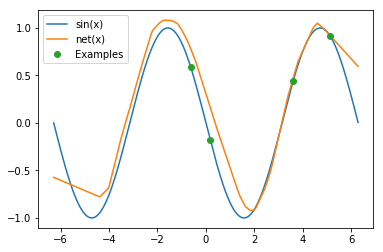

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.savefig('maml-sine.png')